In [12]:
import sys, pathlib, importlib
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

proj_root = pathlib.Path("..").resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

import src.features as ft
import src.external_data as ed

importlib.reload(ft)
importlib.reload(ed)

from src.data_loading import load_eurusd
from src.modeling import (
    train_test_split_time,
    build_logreg_pipeline,
    build_random_forest,
    build_gradient_boosting,
)
from src.evaluation import evaluate_classifier
from src.inference import predict_date_ensemble
from src.config import TARGET_COL, FEATURE_COLS

add_features = ft.add_features
load_vix = ed.load_vix


In [13]:
df = load_eurusd()
vix = load_vix()

df = df.merge(vix, on="date", how="left")
df["vix"] = df["vix"].ffill()

df_feat = add_features(df).sort_values("date").reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split_time(df_feat, test_size=0.2)

print(df_feat.shape)
print("Train size:", len(X_train), "| Test size:", len(X_test))
print("Target balance:")
print(df_feat[TARGET_COL].value_counts(normalize=True).round(3))

df_feat[["date"] + [c for c in FEATURE_COLS if c in df_feat.columns]].tail(5)


(9267, 20)
Train size: 7413 | Test size: 1854
Target balance:
y_up
1    0.502
0    0.498
Name: proportion, dtype: float64


,date,ret_lag1,ret_lag2,ret_lag3,ret_lag5,ret_rollmean_5,ret_rollstd_5,ret_rollstd_10,ret_rollstd_20,abs_ret_lag1,range_pct,vix_lag1
9262,2025-10-17,0.003822,0.003084,0.003128,0.004107,0.001001,0.003299,0.003726,0.003673,0.003822,0.006084,25.31
9263,2025-10-20,-0.001514,0.003822,0.003084,-0.003513,0.001260,0.002880,0.003700,0.003519,0.001514,0.003143,20.78
9264,2025-10-21,-0.002219,-0.001514,0.003822,0.003128,-0.000051,0.003281,0.003593,0.003541,0.002219,0.004929,18.23
9265,2025-10-22,-0.003426,-0.002219,-0.001514,0.003084,-0.000533,0.002855,0.003535,0.003312,0.003426,0.003875,17.87
9266,2025-10-23,0.000672,-0.003426,-0.002219,0.003822,-0.001590,0.001492,0.003054,0.002995,0.000672,0.002052,18.60


In [6]:
xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=0,
)

xgb_model.fit(X_train, y_train)
evaluate_classifier(xgb_model, X_train, y_train, X_test, y_test, name="XGBoost (advanced)")


=== XGBoost (advanced) ===
Accuracy: 0.504
ROC-AUC : 0.506
Confusion matrix:
 [[425 498]
 [421 510]]

Classification report:
               precision    recall  f1-score   support

           0      0.502     0.460     0.480       923
           1      0.506     0.548     0.526       931

    accuracy                          0.504      1854
   macro avg      0.504     0.504     0.503      1854
weighted avg      0.504     0.504     0.503      1854



(0.5043149946062567, 0.505595167302252)

In [7]:
# Version plus robuste des algos du cours (avec hyperparams un peu mieux réglés)
lr = build_logreg_pipeline()
rf = build_random_forest()
gb = build_gradient_boosting()

for m in [lr, rf, gb]:
    m.fit(X_train, y_train)

evaluate_classifier(lr, X_train, y_train, X_test, y_test, name="LogReg (advanced config)")
evaluate_classifier(rf, X_train, y_train, X_test, y_test, name="RandomForest (advanced config)")
evaluate_classifier(gb, X_train, y_train, X_test, y_test, name="GradientBoosting (advanced config)")


=== LogReg (advanced config) ===
Accuracy: 0.504
ROC-AUC : 0.496
Confusion matrix:
 [[334 589]
 [331 600]]

Classification report:
               precision    recall  f1-score   support

           0      0.502     0.362     0.421       923
           1      0.505     0.644     0.566       931

    accuracy                          0.504      1854
   macro avg      0.503     0.503     0.493      1854
weighted avg      0.503     0.504     0.494      1854

=== RandomForest (advanced config) ===
Accuracy: 0.497
ROC-AUC : 0.499
Confusion matrix:
 [[313 610]
 [322 609]]

Classification report:
               precision    recall  f1-score   support

           0      0.493     0.339     0.402       923
           1      0.500     0.654     0.567       931

    accuracy                          0.497      1854
   macro avg      0.496     0.497     0.484      1854
weighted avg      0.496     0.497     0.485      1854

=== GradientBoosting (advanced config) ===
Accuracy: 0.511
ROC-AUC : 0.52
Co

(0.511326860841424, 0.5198978719046494)

In [8]:
models = {
    "LogReg": lr,
    "RandomForest": rf,
    "GradientBoosting": gb,
    "XGBoost": xgb_model,
}

res = predict_date_ensemble(
    df_feat=df_feat,
    models=models,
    date=None,
    test_size=0.2,
    random_state=42
)

print("=== Single-date ensemble prediction (random TEST date) ===")
print("Date:", res["date"])
print("Probabilités UP par modèle:", res["model_probas_up"])
print("Moyenne P(UP):", round(res["avg_proba_up"], 3))
print("Prédiction J+1:", res["predicted_direction"])
print("Vérité terrain y_up:", res["actual_y_up"])


=== Single-date ensemble prediction (random TEST date) ===
Date: 2019-04-12 00:00:00
Probabilités UP par modèle: {'LogReg': 0.4950935477258546, 'RandomForest': 0.5191494412361287, 'GradientBoosting': 0.5417275052143741, 'XGBoost': 0.5474579930305481}
Moyenne P(UP): 0.526
Prédiction J+1: UP
Vérité terrain y_up: 1


In [9]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ("lr", build_logreg_pipeline()),
        ("rf", build_random_forest()),
        ("gb", build_gradient_boosting()),
        ("xgb", xgb_model),
    ],
    voting="soft",
)

ensemble.fit(X_train, y_train)
evaluate_classifier(ensemble, X_train, y_train, X_test, y_test, name="Voting ensemble (with XGB)")


=== Voting ensemble (with XGB) ===
Accuracy: 0.497
ROC-AUC : 0.508
Confusion matrix:
 [[378 545]
 [388 543]]

Classification report:
               precision    recall  f1-score   support

           0      0.493     0.410     0.448       923
           1      0.499     0.583     0.538       931

    accuracy                          0.497      1854
   macro avg      0.496     0.496     0.493      1854
weighted avg      0.496     0.497     0.493      1854



(0.4967637540453074, 0.5081000752927047)

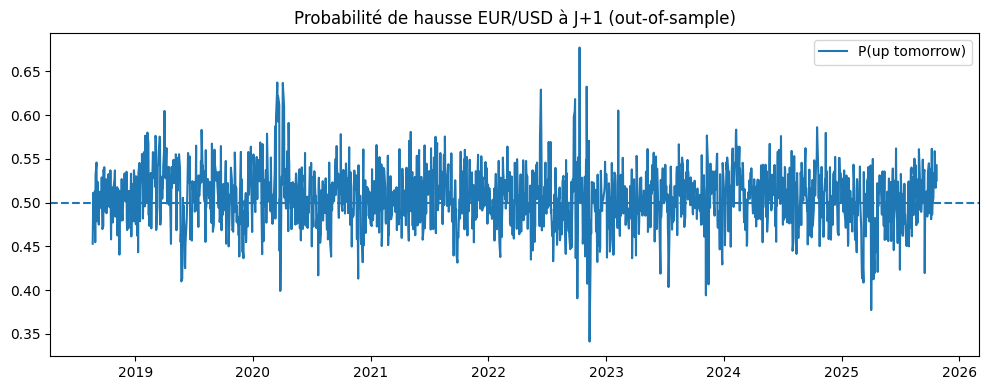

In [10]:
best_model = ensemble
proba = best_model.predict_proba(X_test)[:, 1]

cut = int(len(df_feat) * 0.8)
df_test = df_feat.iloc[cut:].copy()

plt.figure(figsize=(10, 4))
plt.plot(df_test["date"], proba, label="P(up tomorrow)")
plt.axhline(0.5, linestyle="--")
plt.title("Probabilité de hausse EUR/USD à J+1 (out-of-sample)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

# Assure-toi que df_feat est déjà construit plus haut avec VIX
df_feat = df_feat.sort_values("date").reset_index(drop=True)

n = len(df_feat)
cut = int(n * 0.8)

all_dates = df_feat["date"].dt.strftime("%Y-%m-%d").tolist()
test_dates = df_feat.iloc[cut:]["date"].dt.strftime("%Y-%m-%d").tolist()

scope_toggle = widgets.ToggleButtons(
    options=[("Test (20% fin)", "test"), ("Toutes dates", "all")],
    value="test",
    description="Scope:"
)

date_dd = widgets.Dropdown(
    options=test_dates,
    description="Date:",
    layout=widgets.Layout(width="260px")
)

btn = widgets.Button(description="Prédire")
out = widgets.Output()

def update_dates(change=None):
    date_dd.options = test_dates if scope_toggle.value == "test" else all_dates
    if len(date_dd.options) > 0:
        date_dd.value = date_dd.options[0]

scope_toggle.observe(update_dates, names="value")

def predict_for_date(date_str):
    date = pd.to_datetime(date_str)

    row_df = df_feat[df_feat["date"] == date]
    if row_df.empty:
        raise ValueError("Date introuvable dans df_feat.")
    row = row_df.iloc[0]

    eur_close = float(row["close"]) if "close" in row else None
    vix_val = float(row["vix"]) if "vix" in row and pd.notna(row["vix"]) else None

    X_row = row[FEATURE_COLS].values.reshape(1, -1)

    probas = {name: float(m.predict_proba(X_row)[0, 1]) for name, m in models.items()}
    avg = float(sum(probas.values()) / len(probas))
    direction = "UP" if avg >= 0.5 else "DOWN"

    actual = int(row["y_up"]) if "y_up" in row else None

    return eur_close, vix_val, probas, avg, direction, actual

def run_pred(_):
    with out:
        out.clear_output()
        eur_close, vix_val, probas, avg, direction, actual = predict_for_date(date_dd.value)

        print("Date:", date_dd.value)
        print("EUR/USD close:", eur_close)
        print("VIX:", vix_val if vix_val is not None else "NA")
        print("Probabilités UP par modèle:", probas)
        print("Moyenne P(UP):", round(avg, 3))
        print("Prédiction J+1:", direction)
        print("Vérité terrain y_up:", actual)

btn.on_click(run_pred)

display(widgets.HBox([scope_toggle, date_dd, btn]))
display(out)


Output()